In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from tqdm.notebook import tqdm

In [30]:
# First we initialize the dataset object
class MNIST_Dataset(Dataset):

    def __init__(self, image_file, label_file, mode = 'train', validation_split = (-1,-1), transform = None):
        '''
        Initialises the dataset object with the inputs:
            - image_file (str): path to ubyte file with images
            - label_file (str): path to ubyte file with labels
            - mode (str) indicates whether this loads the training or validation dataset
            - validation_split (tuple (float, int))
                validation_split[0] specifies the percentage of the data to be used for validation
                validation_split[1] specifies the random seed (needed for reproducibility to split two different  objects in the same way)
            if any of the two numbers are negative no split will be done
            - transform: transformation to apply to the data
        '''
        # We read the images and the labels, and check if they have the same length
        self.images = self.read_images(image_file)
        self.labels = self.read_labels(label_file)
        if len(self.images)!=len(self.labels):
            raise Exception("Number of images and labels do not match")
            
        # Register the transform as an attribute
        self.transform = transform

        # We want to split the dataset to also get evaluation data
        if validation_split[0]>0 and validation_split[1]>0:
            # Note, i specify the random state in validation_split[1] for  reproducibility
            train_images, val_images, train_labels, val_labels = train_test_split(
                self.images, self.labels, test_size=validation_split[0], random_state=validation_split[1])

            # Depending on the mode we either save as attribute the training data or the testing data
            if mode == 'train':
                self.images = train_images
                self.labels = train_labels
                
            elif mode == 'val':
                self.images = val_images
                self.labels = val_labels

    def __len__(self):
        '''
        Method for the length of the object
        '''
        return len(self.images)

    def __getitem__(self, idx):
        '''
        Method to extract an item from the object
            - idx: positional index of data within the object (i.e. within each array of images-labels)
        '''
        # If specified, we apply the transform to the image
        if self.transform!=None:
            return self.transform(self.images[idx]), self.labels[idx]
        
        else:
            return self.images[idx], self.labels[idx]

    def read_images(self, filename):
        '''
        Function to read in the images from the MNIST format
            - filename (str): path to the data file
        '''
        with open(filename, 'rb') as f:
            # Read header information
            magic_number = int.from_bytes(f.read(4), byteorder='big')
            self.num_images = int.from_bytes(f.read(4), byteorder='big')
            self.num_rows = int.from_bytes(f.read(4), byteorder='big')
            self.num_cols = int.from_bytes(f.read(4), byteorder='big')
            
            # Read the image data
            buffer = f.read(self.num_images * self.num_rows * self.num_cols)
            images = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)

            # Return normalised images
            return images.reshape(self.num_images, self.num_rows, self.num_cols) / 255.0

    def read_labels(self, filename):
        '''
        Function to read in the labels from the MNIST format
            - filename (str): path to the data file
        '''
        with open(filename, 'rb') as f:
            # Read header information
            magic_number = int.from_bytes(f.read(4), byteorder='big')
            num_labels = int.from_bytes(f.read(4), byteorder='big')

            # Read the label data
            buffer = f.read(num_labels)
            labels = np.frombuffer(buffer, dtype=np.uint8)
            
            return labels

We have 60000 training images and 10000 testing images
See this example:


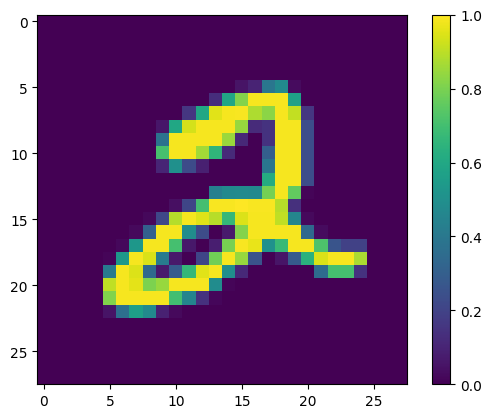

2


In [31]:
# Paths to training images (these are from kaggle as they have GPUs available)
training_images = '/kaggle/input/mnist-dataset/train-images.idx3-ubyte'
training_labels = '/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
testing_images = '/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte'
testing_labels = '/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'

# Load in the training data with no transform for testing reasons to see if everything works correctly
training_data = MNIST_Dataset(image_file=training_images, label_file=training_labels,transform=None)
testing_data = MNIST_Dataset(image_file=testing_images, label_file=testing_labels,transform=None)

print(f"We have {len(training_data)} training images and {len(testing_data)} testing images")
print("See this example:")
plt.figure()
plt.imshow(training_data[5][0])
plt.colorbar()
plt.show()
plt.close()
print(training_data[5][1])

In [32]:
# Having checked everything is correct we initialize the data as a tensor

# Define validation split fraction and random seed for reproducibility
validation_split = (0.166,43)

# Define dataset objects
training_data = MNIST_Dataset(image_file=training_images, label_file=training_labels, validation_split = validation_split, mode = 'train', transform=transforms.ToTensor())
validation_data = MNIST_Dataset(image_file=training_images, label_file=training_labels, validation_split = validation_split, mode = 'val', transform=transforms.ToTensor())
testing_data = MNIST_Dataset(image_file=testing_images, label_file=testing_labels,transform=transforms.ToTensor())

print(training_data.images.shape)
print(validation_data.images.shape)

# We batch the datasets and produce the data loader iterables
dataloader_training = DataLoader(training_data, batch_size = 64, shuffle = True)
dataloader_val = DataLoader(validation_data, batch_size = 64, shuffle = False)
dataloader_testing = DataLoader(testing_data, batch_size = 64, shuffle = False)

(50040, 28, 28)
(9960, 28, 28)


In [33]:
# Now we create the class for the neural network itself

class MNIST_Classifier(nn.Module):
    def __init__(self, num_classes = 10, dropout_rate = 0.5):
        '''
        Initialises the network class inheriting everything from nn.Module from pytorch
            - num_classes (int): number of possible output classes
            - dropout_rate (float): fraction of cells set to zero during dropout
        '''
        # Inherit the initialization from the superior class nn.Module
        super(MNIST_Classifier, self).__init__()

        # We now construct a sequence of convolutional-max pooling layers
        # Convolutional layer -> Maxpooling layer -> ReLU transformation -> Convolutional layer -> Dropout layer -> Max pooling layer -> ReLU transformation
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.Dropout2d(p=dropout_rate),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
        )

        # The result from the previous layers is now flattened (all the channels) and fed into a vanilla neural network:
        # Linear layer -> ReLU transformation -> Dropout layer -> Linear layer
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*4*4, out_features=50),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=50, out_features = num_classes)
        )

    def forward(self,x):
        '''
        Method to feedforward from input to output of the layer
        '''
        return self.dense_layers(self.conv_layers(x))



In [34]:

def train(model, train_loader, val_loader = False, test_loader = False, num_epochs = 40, lr = 0.1, l2_lambda = 0.1, momentum=0.5, patience = 15):
    '''
    Function to train the model
        - model (class): Neural network object to be trained
        - train_loader (iterable): Iterable containing the training dataset (DataLoader)
        - val_loader, test_loader (iterable): Iterable containing the validation and testing datasets (DataLoader). If set to false, no validation/testing information will be extracted
        - num_epochs (int): maximum number of epochs
        - lr (float): Learning rate
        - l2_lambda (float): Weight decay 'lambda' parameter
        - momentum (float): momentum co-efficient parameter
        - patience (int): patience parameter for early stopping. Maximum number of epochs during which the validation accuracy has not improved in order to early stop.
    '''
    # Check if there is a gpu available for use. If not, use a cpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the loss function, the optimizer using the input parameters, and a learning rate decay scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = l2_lambda)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

    # Initialize empty lists of data
    train_losses, val_losses, test_losses, train_accs, val_accs, test_accs = [], [], [], [], [], []

    # Counters for the early stopping
    patience_counter = 0
    best_val_acc = 0.

    # We loop over the epochs
    #for epoch in tqdm(range(num_epochs), desc = 'Epochs'):   I REMOVED THIS LINE BUT IT CAN BE USED TO SHOW A DYNAMIC BAR OF THE PROGRESS
    for epoch in range(num_epochs):
        
        # Model into train mode
        model.train()

        # Initialize variables for accuracy and loss calculations
        running_loss = 0.
        correct = 0
        total = 0

        # Iterate over the items in the loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()                   # Set the gradients to zero
            outputs = model(inputs)                 # Feedforward the inputs to the outputs
            loss = criterion(outputs, labels)       # Calculate the loss
            loss.backward()                         # Backpropagate the error
            optimizer.step()                        # Correct the parameters

            # We multiply the running loss by labels.size(0) (the batch size) because the loss function returns the average loss per sample in the batch. We calculate the actual loss and then we will average over the entire dataset
            running_loss += loss.item() * labels.size(0)

            # Now we compute the maximum value across dimension 1 (the classes), and returns "_", the maximum score for each sample, and "predicted", their positions
            _, predicted = torch.max(outputs, 1)

            # We find which are correct by comparing the predicted values with their labels and sum them over
            correct += (predicted == labels).sum().item()

        # We calculate the average training loss of the whole dataset
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # We calculate the accuracy on the model
        train_accuracy = correct / len(train_loader.dataset)
        train_accs.append(train_accuracy)
        
        #################### Validation ##################################
        # If there is no validation set then we only print the training information
        if not val_loader and epoch%10==0:
            print(f"Epoch [{epoch+1} / {num_epochs}] \nAccuracy on training data: {train_accuracy*100.:.2f}%")
            
        # If there is we perform a validation set study as well
        elif val_loader:
            # Model into evaluation mode
            model.eval()

            # Variables for the loss and accuracy calculation
            running_loss = 0.
            correct = 0

            # Disable gradient computation
            with torch.no_grad():
                # Loop over the data in the evaluation set and perform a process analogous to the testing case, without modifying the parameters
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    running_loss += loss.item() * labels.size(0)

                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()

            val_loss = running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)
            val_accuracy = correct / len(val_loader.dataset)
            val_accs.append(val_accuracy)

            # Print the results for the current epoch
            print(f"Epoch [{epoch+1} / {num_epochs}] \nAccuracy on training data: {train_accuracy*100.:.2f}% \nAccuracy on validation data: {val_accuracy*100.:.2f}%")

            # Now we check if the accuracy is improving for the early stopping case
            if best_val_acc < val_accuracy:
                patience_counter = 0
                best_val_acc = val_accuracy
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"\nEarly stop at epoch {epoch + 1}\n")
                break
            
        # Advance the scheduler (i.e. evolve the learning rate)
        scheduler.step(val_accuracy)

        # Get the testing set current loss and accuracy
        if test_loader:
            test_loss, test_acc = test(model, test_loader)
            test_losses.append([epoch,test_loss])
            test_accs.append([epoch,test_acc])
    
    # Return the result
    return np.array(train_losses), np.array(val_losses), np.array(test_losses), np.array(train_accs), np.array(val_accs), np.array(test_accs)
    

def test(model, test_loader):
    '''
    Function to calculate the loss and accuracy of passing the testing data through the model
        - model (class): Neural network object to be trained
        - test_loader (iterable): Iterable containing the training dataset (DataLoader)
    '''
    # The process is analogous to the testing and validation cases above
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    running_loss = 0.
    correct = 0.
    
    for inputs, labels in test_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * labels.size(0)
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    return  running_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

In [35]:
# Define the model and the device
model = MNIST_Classifier(num_classes = 10, dropout_rate = 0.1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# We train the model!
train_losses, val_losses, test_losses, train_accs, val_accs, test_accs = train(
    model, dataloader_training, dataloader_val, dataloader_testing,
    num_epochs = 200, lr = 0.01, l2_lambda = 0.01, momentum=0.3, patience = 30)

# We calculate the testing accuracy of the resulting model
print(f"\nFinal testing accuracy: {test(model,dataloader_testing)[1]*100.:.3f}")

Epoch [1 / 200] 
Accuracy on training data: 71.04% 
Accuracy on validation data: 90.43%
Epoch [2 / 200] 
Accuracy on training data: 91.71% 
Accuracy on validation data: 94.39%
Epoch [3 / 200] 
Accuracy on training data: 94.30% 
Accuracy on validation data: 95.31%
Epoch [4 / 200] 
Accuracy on training data: 95.38% 
Accuracy on validation data: 96.30%
Epoch [5 / 200] 
Accuracy on training data: 95.83% 
Accuracy on validation data: 96.54%
Epoch [6 / 200] 
Accuracy on training data: 96.26% 
Accuracy on validation data: 96.78%
Epoch [7 / 200] 
Accuracy on training data: 96.50% 
Accuracy on validation data: 96.96%
Epoch [8 / 200] 
Accuracy on training data: 96.59% 
Accuracy on validation data: 96.86%
Epoch [9 / 200] 
Accuracy on training data: 96.82% 
Accuracy on validation data: 97.27%
Epoch [10 / 200] 
Accuracy on training data: 96.85% 
Accuracy on validation data: 97.23%
Epoch [11 / 200] 
Accuracy on training data: 96.95% 
Accuracy on validation data: 97.41%
Epoch [12 / 200] 
Accuracy on 

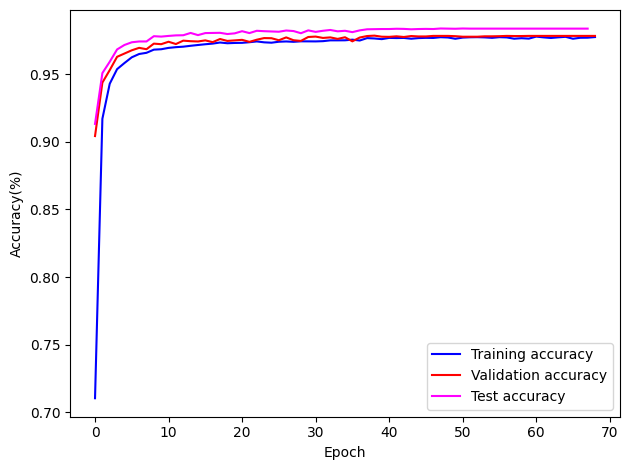

In [38]:
# We plot the results
fig,ax = plt.subplots(1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy(%)')
ax.plot(train_accs, 'b', label = 'Training accuracy')
ax.plot(val_accs, 'r', label = 'Validation accuracy')
ax.plot(test_accs[:,1], color='fuchsia',label = 'Test accuracy')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()
